# ABEL linac tracking example

By Carl A. Lindstrøm (University of Oslo), 8 Sep 2023

### Import ABEL framework

In [1]:
import sys
sys.path.append('../')
from abel import *
import numpy as np
%load_ext autoreload
%autoreload 2

### Define the linac and beams

In [2]:
# define driver
driver = SourceBasic()
driver.charge = -2.7e10 * SI.e # [C]
driver.energy = 31.25e9 # [eV]
driver.rel_energy_spread = 0.01
driver.bunch_length = 42e-6 # [m]
driver.z_offset = 300e-6 # [m]
driver.emit_nx, driver.emit_ny = 10e-6, 10e-6 # [m rad]
driver.beta_x, driver.beta_y = 30e-3, 30e-3 # [m]
driver.num_particles = 10000
driver.jitter.x = 0e-9 # [m]
driver.jitter.y = 0e-9 # [m]
drive_beam = driver.track()  # Convert a Source object to a Beam object.  ######

# define stage
stage = StageQuasistatic2d()
stage.enable_transverse_instability = True
#stage = StagePrtclTransWakeInstability()                      #######
stage.drive_beam = drive_beam                                 #######
stage.driver_source = driver
stage.nom_energy_gain = 31.9e9 # [eV]
stage.length = 5 # [m]
stage.plasma_density = 7e21 # [m^-3]
stage.ramp_beta_mag = 5
stage.enable_radiation_reaction = False

# define first stage (half length)
first_stage = StageQuasistatic2d()
first_stage.enable_transverse_instability = stage.enable_transverse_instability
#first_stage = StagePrtclTransWakeInstability()                      #######
first_stage.drive_beam = drive_beam                                 #######
first_stage.driver_source = driver
first_stage.nom_energy_gain = stage.nom_energy_gain/2
first_stage.length = stage.length/2
first_stage.plasma_density = stage.plasma_density
first_stage.ramp_beta_mag = stage.ramp_beta_mag
first_stage.enable_radiation_reaction = stage.enable_radiation_reaction

# define beam
source = SourceBasic()
source.charge = -1e10 * SI.e # [C]
source.energy = 5e9 # [eV]
#source.rel_energy_spread = 0.1
source.rel_energy_spread = 0.005
source.bunch_length = 18e-6 # [m]
source.z_offset = -36e-6 # [m]
source.emit_nx, source.emit_ny = 160e-6, 0.56e-6 # [m rad]
source.beta_x = stage.matched_beta_function(source.energy)
source.beta_y = source.beta_x
#source.num_particles = 5000
source.num_particles = 6000
source.jitter.t = driver.jitter.t

main_gamma = energy2gamma(source.energy)
main_sigma_x = np.sqrt(source.emit_nx/main_gamma*source.beta_x)  # [m]
main_sigma_y = np.sqrt(source.emit_ny/main_gamma*source.beta_y)  # [m]
source.x_offset = main_sigma_x*0.1  # [m]
source.y_offset = main_sigma_y*0.1  # [m]

# define interstage
interstage = InterstageBasic()
#interstage = InterstageElegant()
interstage.beta0 = lambda E: stage.matched_beta_function(E)
interstage.dipole_length = lambda E: 1 * np.sqrt(E/10e9) # [m(eV)]
interstage.dipole_field = 0.5  # [T]
#interstage.dipole_field = lambda E: np.min([1.0, 100e9/E]) # [T]

# beam delivery system
bds = BeamDeliverySystemBasic()
bds.beta_x, bds.beta_y = 8e-3, 0.4e-3 # [m]
bds.bunch_length = 0.75 * bds.beta_y

# define linac
linac = Linac()
linac.source = source
linac.stage = stage
linac.first_stage = first_stage
linac.interstage = interstage
linac.num_stages = 16

### Run simulations

In [3]:
linac.run('linac_example', num_shots=1, overwrite=True, parallel=False);

Tracking element 1 (SourceBasic, stage 0, s = 0.0 m, 5.0 GeV, -1.60 nC, 0.5% rms, 162.2/0.6 µm-rad)


Instability tracking 100.08%: 100%|██████| 100.0766712186922/100 [00:17<00:00,  5.83it/s]


Tracking element 2 (StageQuasistatic2d, stage 1, s = 2.5 m, 21.4 GeV, -1.60 nC, 3.6% rms, 162.8/0.6 µm-rad)
Tracking element 3 (InterstageBasic, stage 1, s = 9.4 m, 21.4 GeV, -1.60 nC, 3.6% rms, 162.8/0.6 µm-rad)


Instability tracking 100.11%: 100%|█████| 100.10811702308816/100 [00:14<00:00,  7.01it/s]


Tracking element 4 (StageQuasistatic2d, stage 2, s = 14.4 m, 53.6 GeV, -1.60 nC, 3.1% rms, 163.1/0.6 µm-rad)
Tracking element 5 (InterstageBasic, stage 2, s = 25.4 m, 53.6 GeV, -1.60 nC, 3.1% rms, 163.1/0.6 µm-rad)


Instability tracking 100.06%: 100%|█████| 100.06336135741145/100 [00:09<00:00, 10.93it/s]


Tracking element 6 (StageQuasistatic2d, stage 3, s = 30.4 m, 85.6 GeV, -1.60 nC, 2.7% rms, 163.0/0.6 µm-rad)
Tracking element 7 (InterstageBasic, stage 3, s = 44.4 m, 85.6 GeV, -1.60 nC, 2.7% rms, 163.0/0.6 µm-rad)


Instability tracking 100.1%: 100%|██████| 100.09628102569334/100 [00:07<00:00, 13.78it/s]


Tracking element 8 (StageQuasistatic2d, stage 4, s = 49.4 m, 117.6 GeV, -1.60 nC, 2.3% rms, 162.8/0.6 µm-rad)
Tracking element 9 (InterstageBasic, stage 4, s = 65.7 m, 117.6 GeV, -1.60 nC, 2.3% rms, 163.0/0.6 µm-rad)


Instability tracking 100.21%: 100%|██████| 100.2108752163682/100 [00:06<00:00, 16.41it/s]


Tracking element 10 (StageQuasistatic2d, stage 5, s = 70.7 m, 149.5 GeV, -1.60 nC, 2.0% rms, 162.7/0.6 µm-rad)
Tracking element 11 (InterstageBasic, stage 5, s = 89.2 m, 149.5 GeV, -1.60 nC, 2.0% rms, 162.7/0.6 µm-rad)


Instability tracking 100.15%: 100%|█████| 100.15296843625632/100 [00:05<00:00, 18.47it/s]


Tracking element 12 (StageQuasistatic2d, stage 6, s = 94.2 m, 181.2 GeV, -1.60 nC, 1.7% rms, 162.4/0.6 µm-rad)
Tracking element 13 (InterstageBasic, stage 6, s = 114.5 m, 181.2 GeV, -1.60 nC, 1.7% rms, 162.4/0.6 µm-rad)


Instability tracking 100.18%: 100%|█████| 100.17678715869249/100 [00:04<00:00, 20.11it/s]


Tracking element 14 (StageQuasistatic2d, stage 7, s = 119.5 m, 213.1 GeV, -1.60 nC, 1.5% rms, 162.1/0.6 µm-rad)
Tracking element 15 (InterstageBasic, stage 7, s = 141.6 m, 213.1 GeV, -1.60 nC, 1.5% rms, 162.1/0.6 µm-rad)


Instability tracking 100.25%: 100%|█████| 100.24666477657087/100 [00:04<00:00, 21.99it/s]


Tracking element 16 (StageQuasistatic2d, stage 8, s = 146.6 m, 244.6 GeV, -1.60 nC, 1.3% rms, 161.8/0.6 µm-rad)
Tracking element 17 (InterstageBasic, stage 8, s = 170.2 m, 244.6 GeV, -1.60 nC, 1.3% rms, 161.7/0.6 µm-rad)


Instability tracking 100.38%: 100%|█████| 100.37987708066196/100 [00:04<00:00, 23.81it/s]


Tracking element 18 (StageQuasistatic2d, stage 9, s = 175.2 m, 276.2 GeV, -1.60 nC, 1.2% rms, 161.4/0.6 µm-rad)
Tracking element 19 (InterstageBasic, stage 9, s = 200.4 m, 276.2 GeV, -1.60 nC, 1.2% rms, 161.4/0.6 µm-rad)


Instability tracking 100.01%: 100%|█████| 100.01283144978721/100 [00:04<00:00, 24.24it/s]


Tracking element 20 (StageQuasistatic2d, stage 10, s = 205.4 m, 307.5 GeV, -1.60 nC, 1.1% rms, 161.1/0.6 µm-rad)
Tracking element 21 (InterstageBasic, stage 10, s = 232.0 m, 307.5 GeV, -1.60 nC, 1.1% rms, 161.1/0.6 µm-rad)


Instability tracking 100.27%: 100%|█████| 100.27397644437383/100 [00:03<00:00, 25.92it/s]


Tracking element 22 (StageQuasistatic2d, stage 11, s = 237.0 m, 339.0 GeV, -1.60 nC, 1.1% rms, 160.7/0.6 µm-rad)
Tracking element 23 (InterstageBasic, stage 11, s = 264.9 m, 339.0 GeV, -1.60 nC, 1.1% rms, 160.7/0.6 µm-rad)


Instability tracking 100.23%: 100%|█████| 100.22779214190824/100 [00:03<00:00, 28.19it/s]


Tracking element 24 (StageQuasistatic2d, stage 12, s = 269.9 m, 370.4 GeV, -1.60 nC, 1.1% rms, 160.4/0.6 µm-rad)
Tracking element 25 (InterstageBasic, stage 12, s = 299.1 m, 370.4 GeV, -1.60 nC, 1.1% rms, 160.4/0.6 µm-rad)


Instability tracking 100.43%: 100%|█████| 100.43415034038756/100 [00:03<00:00, 28.41it/s]


Tracking element 26 (StageQuasistatic2d, stage 13, s = 304.1 m, 401.4 GeV, -1.60 nC, 1.1% rms, 160.2/0.6 µm-rad)
Tracking element 27 (InterstageBasic, stage 13, s = 334.5 m, 401.4 GeV, -1.60 nC, 1.1% rms, 160.1/0.6 µm-rad)


Instability tracking 100.06%: 100%|█████| 100.05880951273186/100 [00:03<00:00, 29.54it/s]


Tracking element 28 (StageQuasistatic2d, stage 14, s = 339.5 m, 432.5 GeV, -1.60 nC, 1.2% rms, 159.8/0.6 µm-rad)
Tracking element 29 (InterstageBasic, stage 14, s = 371.1 m, 432.5 GeV, -1.60 nC, 1.2% rms, 159.7/0.6 µm-rad)


Instability tracking 100.22%: 100%|█████| 100.22406967297816/100 [00:03<00:00, 30.06it/s]


Tracking element 30 (StageQuasistatic2d, stage 15, s = 376.1 m, 463.6 GeV, -1.60 nC, 1.2% rms, 159.3/0.6 µm-rad)
Tracking element 31 (InterstageBasic, stage 15, s = 408.8 m, 463.6 GeV, -1.60 nC, 1.2% rms, 159.3/0.6 µm-rad)


Instability tracking 100.54%: : 100.53550236007123it [00:03, 32.17it/s]                  


Tracking element 32 (StageQuasistatic2d, stage 16, s = 413.8 m, 494.6 GeV, -1.60 nC, 1.3% rms, 158.9/0.6 µm-rad)


### Plot the wakefield

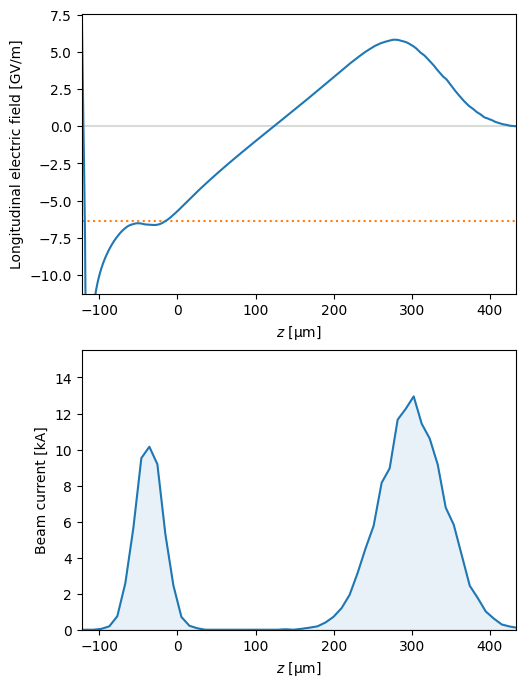

In [4]:
# plot the first-stage wakefield
linac.stages[0].plot_wakefield()

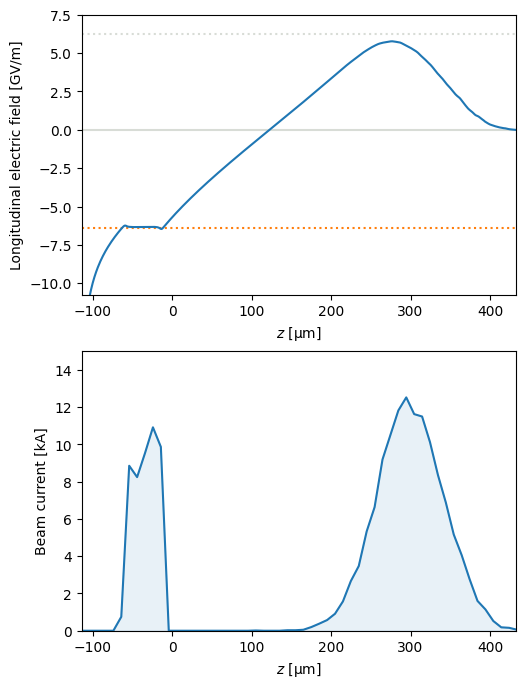

In [5]:
# plot the last-stage wakefield
linac.stages[-1].plot_wakefield()

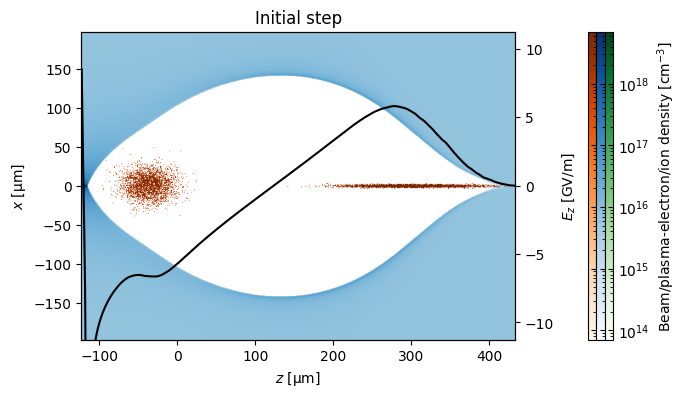

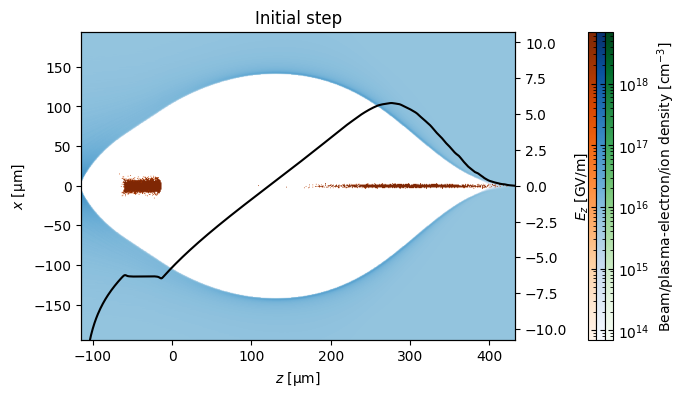

In [6]:
linac.stages[0].plot_wake()
linac.stages[-1].plot_wake()

### Plot beam evolution and survey

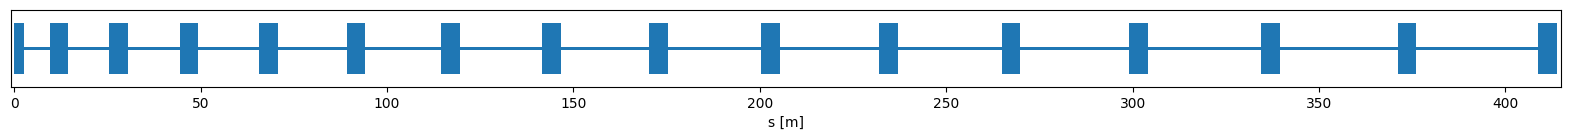

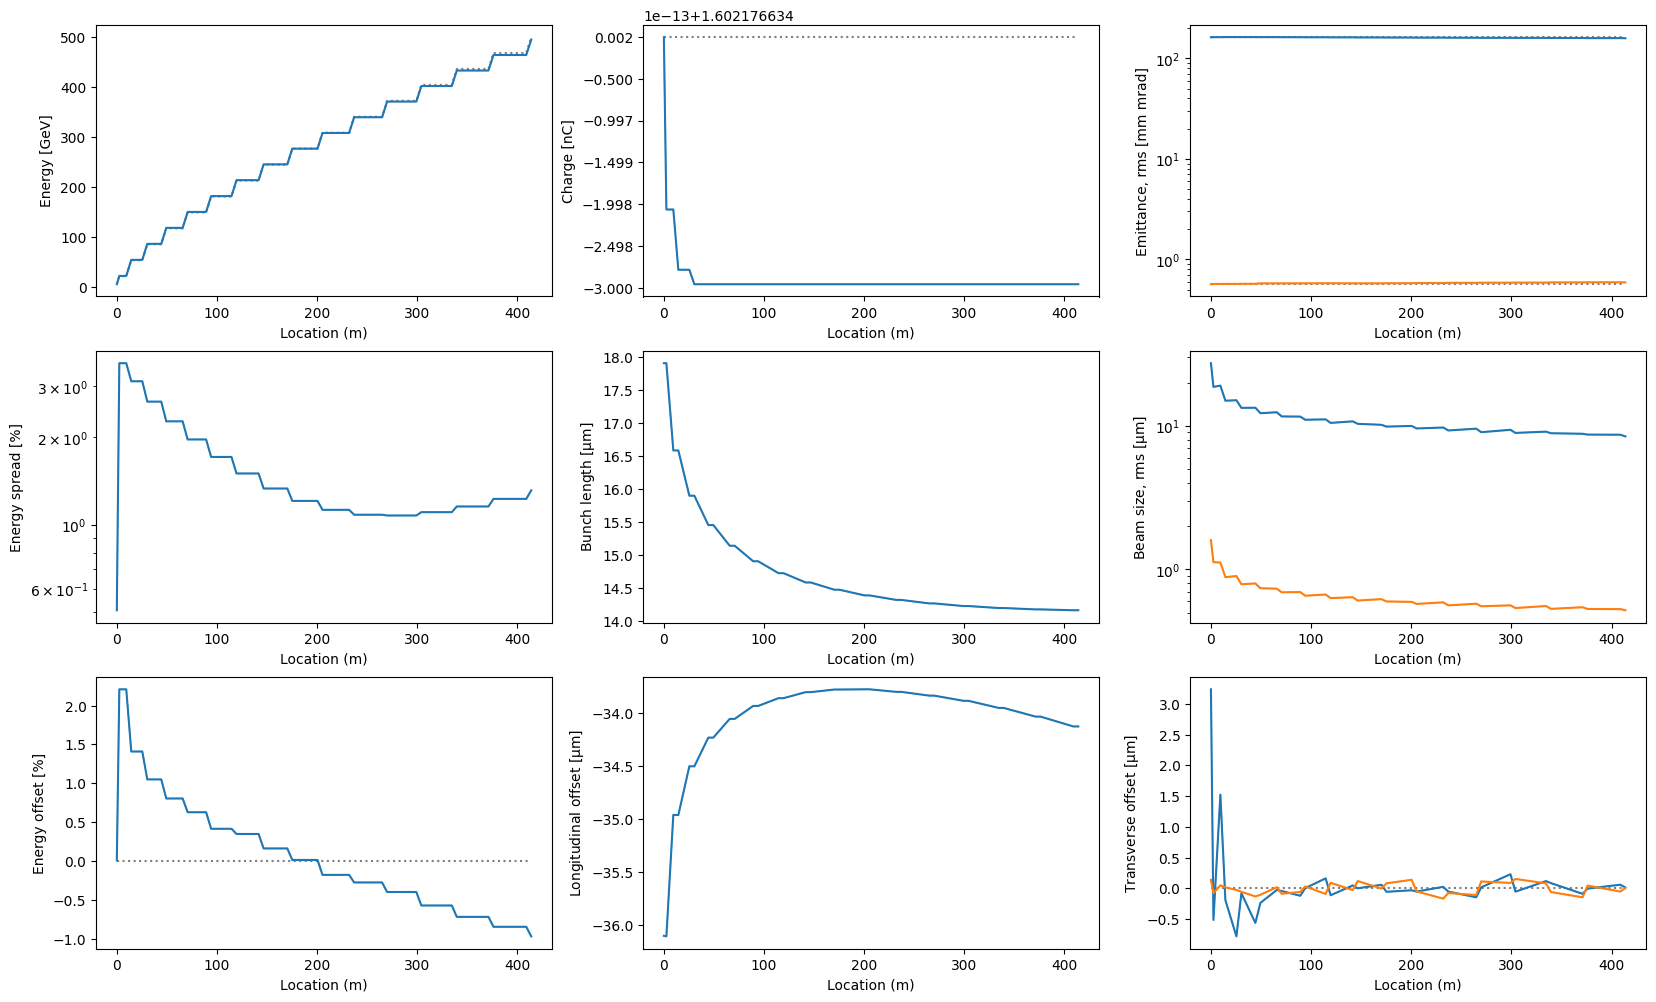

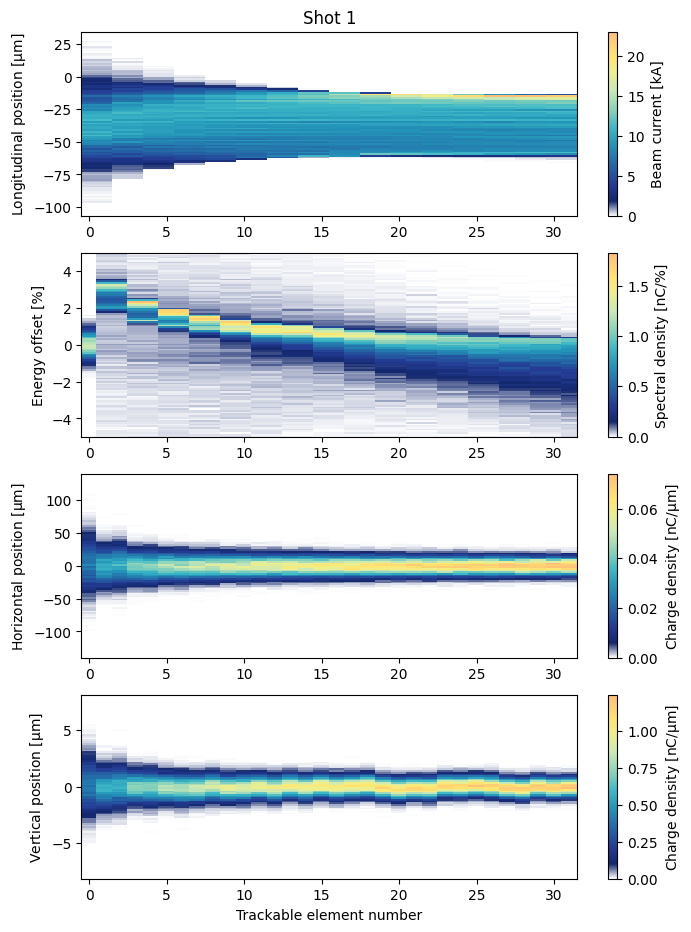

In [7]:
# plot linac survey
linac.plot_survey()

# plot beam evolution
linac.plot_evolution(use_stage_nums=False)
linac[0].plot_waterfalls()

In [8]:
linac.animate_lps()

'run_data/linac_example/plots/lps_shot0.gif'

![](run_data/linac_example/plots/lps_shot0.gif)

In [9]:
shot_num = 0
stage_num = 15
stage_tracked = linac[shot_num].stages[stage_num]  # Get a specific acceleration stage in a linac. Zero indexing.
beam_out = linac[shot_num].get_beam(stage_num*2+1)  # Get the corresponding beam after the acceleration stage. Zero indexing.

In [10]:
stage_tracked.print_current_summary(stage_tracked.drive_beam, linac.initial_beam, beam_out)

AttributeError: 'StageQuasistatic2d' object has no attribute 'print_current_summary'